### Setup

In [2]:
import os
import sys
import datetime
import calendar
import itertools
import math

import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.stats.api as sms
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model, unitroot
import warnings
warnings.warn = lambda *a, **kw: False

sys.path.append("..") # Adds higher directory to python modules path for importing from src dir
from src.datasets import NyseStocksDataset, NyseSecuritiesDataset
import src.econometric_utils as eco
import src.regression_utils as regr
import src.plot_utils as plot
import src.math_utils as math_utils

get_month = lambda i: datetime.date(2000, int(i), 1).strftime('%B')
get_weekday = lambda i: calendar.day_name[int(i)]
split = lambda x: (x.iloc[:600], x.iloc[600:])  # train: 2010-01-05 until 2012-05-21, val: 2012-05-21 until 2012-12-31

%matplotlib inline
%load_ext autotime
%load_ext autoreload
%autoreload 2

In [3]:
stocks = NyseStocksDataset('OCMvOC-3C', file_path='../data/nyse/prices-split-adjusted.csv', features=['open', 'close', 'movement', 'vix_open', 'vix_close'], load=True, look_back=1)
securities = NyseSecuritiesDataset(file_path='../data/nyse/securities.csv', load=True)


time: 6.66 s


In [4]:
gspc = stocks.load_gspc().set_index('date')[['gspc_open', 'gspc_close']].rename(lambda x: x.replace('gspc_', ''), axis=1)
gspc = eco.add_movements(gspc)

vix = stocks.load_vix().set_index('date')[['vix_open', 'vix_close']].rename(lambda x: x.replace('vix_', ''), axis=1)
vix = eco.add_movements(vix)

prices = stocks.enhance_features(stocks.prices.copy())
comp_metas, train_comp_prices, val_comp_prices = [], [], []
comp_grouped = prices.groupby(prices.symbol, sort=False)
for sym, p in tqdm(comp_grouped):
    train, val = split(eco.add_movements(p).drop(columns=['symbol', 'movement']).set_index('date'))
    train_comp_prices.append(train)
    val_comp_prices.append(val)
    comp_metas.append({'symbol': sym, 'industry': securities.get_industry(sym), 'name': securities.get_company_name(sym)})

comp_metas = pd.DataFrame(comp_metas)


time: 1min 40s


### Select Industry

In [5]:
def get_industry(ind_name, val=False):
    indizes = comp_metas.index[comp_metas.industry == ind_name]
    for i in indizes:
        _, name, symbol = comp_metas.iloc[i]
        if val:
            yield symbol, name, val_comp_prices[i]
        else:
            yield symbol, name, train_comp_prices[i]

all_industries = comp_metas.industry.unique()
print('Industries:', ', '.join(all_industries))

Industries: Health Care, Industrials, Consumer Discretionary, Information Technology, Consumer Staples, Utilities, Financials, Materials, Real Estate, Energy, Telecommunications Services
time: 310 ms


In [6]:
# e.g. greatest energy companies: XOM, CHK
industry_name = 'Energy'  # 'Information Technology'
industry = list(get_industry(industry_name))
industry_val = list(get_industry(industry_name, val=True))
greatest_comp = np.argmax([(p.volume.max()) for _, _, p in industry])
(symbol, name, price), val_price = industry[greatest_comp], industry_val[greatest_comp][2]

time: 261 ms


Shapiro test (null=normal): p value = 0.0000
Shapiro test (null=normal): p value = 0.0000
Shapiro test (null=normal): p value = 0.0000

Test for Distributions Equality:
>Kolmogorov-Smirnov (null = equal): p value = 1.0000
>Kruskal-Wallis (null = equal): p value = 0.9074
>Mann-Whitney (null = equal): p value = 0.4537

Test for Distributions Equality:
>Kolmogorov-Smirnov (null = equal): p value = 0.9988
>Kruskal-Wallis (null = equal): p value = 0.7601
>Mann-Whitney (null = equal): p value = 0.3801


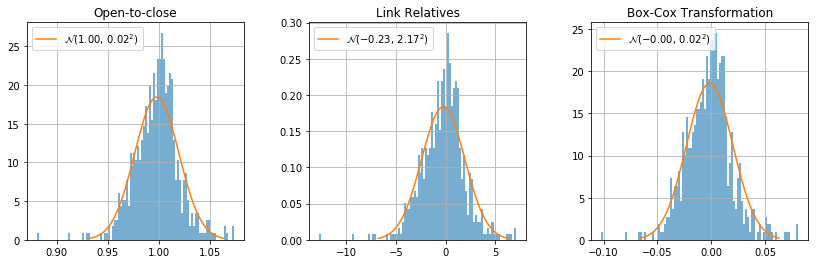

time: 1.88 s


In [7]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
plot.compare_with_normal(price.otc, 'Open-to-close', ax=axes[0])
plot.compare_with_normal(price.lret, 'Link Relatives', ax=axes[1])
plot.compare_with_normal(price.boxcox, 'Box-Cox Transformation', ax=axes[2])
regr.compare_distributions(price.otc - 1, price.lret / 100)
regr.compare_distributions(price.boxcox, price.lret / 100)

### Regression Analysis

#### Characteristics

Test for Unit Root:
>Augmented Dickey-Fuller (null = I(1)): p value = 0.0000
>KPSS (null = I(0)): p value = 0.2056
>Phillips-Perron (null = I(1)): p value = 0.0000

Test for Autocorrelation:
>Durbin-Watson (null(2) = no autocorr., lag 1): statistic = 1.9291
>Ljung-Box-Q (null = no autocorr., lag 1): p value = 0.53

Test for Normal Distribution:
>Jarque-Bera (null = gaussian): p value = 0.0000
>Shapiro-Wilk (null = gaussian): p value = 0.0000
>D’Agostino’s K^2 (null = gaussian): p value = 0.0000
>Anderson-Darling (null = gaussian): p value = 0.0000

Test for Structural Breaks:
>CUSUM test on OLS residuals (null = stable coeff): p value = 0.1974


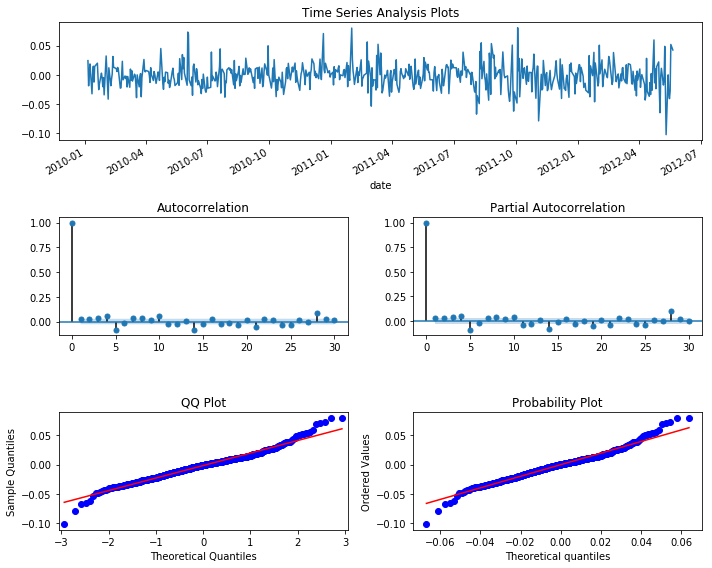

time: 1.13 s


In [7]:
plot.tsplot(price.boxcox);
regr.investigate(price.boxcox, verbose=True);

In [8]:
print(unitroot.ADF(price.boxcox).regression.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.491
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     113.5
Date:                Wed, 03 Apr 2019   Prob (F-statistic):           6.39e-84
Time:                        17:36:03   Log-Likelihood:                 1446.6
No. Observations:                 595   AIC:                            -2881.
Df Residuals:                     589   BIC:                            -2855.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Level.L1      -0.9317      0.086    -10.797      0.0

#### Seasonality

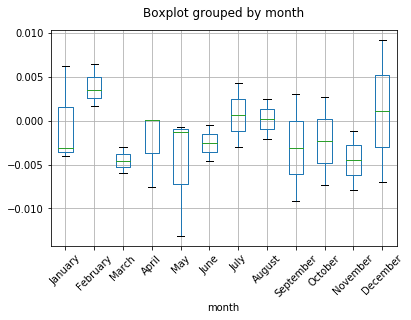

time: 581 ms


In [9]:
r = price.boxcox
monthly_returns = r.groupby([r.index.year.rename('year'), r.index.month.rename('month')]).mean()
monthly_returns = pd.DataFrame(monthly_returns.reset_index().values, columns=('year', 'month', 'return'))
ax = monthly_returns.boxplot(column='return', by='month')
ax.set_title('')
labels = [item.get_text() for item in ax.get_xticklabels()]
plt.xticks(monthly_returns.iloc[:12].month, [get_month(x) for x in monthly_returns.iloc[:12].month], rotation=45)
plt.tick_params(axis='both', which='major')

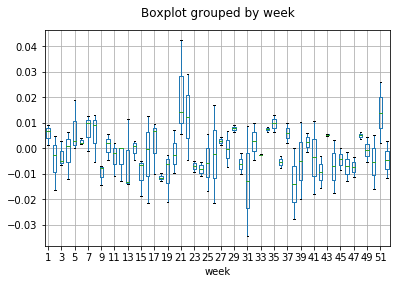

time: 1.14 s


In [10]:
r = price.boxcox
weekly_returns = r.groupby([r.index.year.rename('year'), r.index.week.rename('week')]).mean()
weekly_returns = pd.DataFrame(weekly_returns.reset_index().values, columns=('year', 'week', 'return'))
ax = weekly_returns.boxplot(column='return', by='week')
ax.set_title('')
labels = [item.get_text() for item in ax.get_xticklabels()]
plt.xticks(weekly_returns.iloc[:52:2].week, [int(x) for x in weekly_returns.iloc[:52:2].week])
plt.tick_params(axis='both', which='major')

There is no consistent shape over the years for weekdays

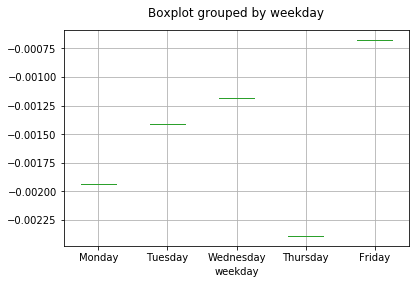

time: 379 ms


In [11]:
r = price.boxcox  # [price.boxcox.index.year == 2010]
daily_returns = r.groupby([r.index.weekday.rename('weekday')]).mean()
daily_returns = pd.DataFrame(daily_returns.reset_index().values, columns=('weekday', 'return'))
ax = daily_returns.boxplot(column='return', by='weekday')
ax.set_title('')
labels = [item.get_text() for item in ax.get_xticklabels()]
plt.xticks(daily_returns.iloc[:5].weekday + 1, [get_weekday(x) for x in daily_returns.iloc[:5].weekday])
plt.tick_params(axis='both', which='major')

In [12]:
a = smt.SARIMAX(price.boxcox, order=(3, 0, 2), seasonal_order=(0, 1, 1, 12))
f = a.fit(trend='nc', update_freq=5)

time: 6.68 s


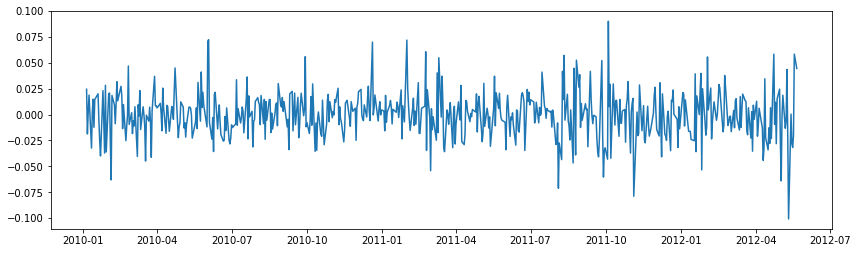

time: 364 ms


In [13]:
plt.subplots(figsize=(14, 4))
plt.plot(f.resid)

- https://medium.com/@a.nejad_99199/exploring-market-seasonality-trends-19a91381c0fe
- https://github.com/anejad/Exploring-Market-Seasonality-Trends/blob/master/Exploring%20Seasonality%20Trends%20in%20Stock%20Market.ipynb
- https://otexts.com/fpp2/components.html
- https://towardsdatascience.com/analysis-of-stock-market-cycles-with-fbprophet-package-in-python-7c36db32ecd0
- https://digitalcommons.wayne.edu/cgi/viewcontent.cgi?article=2030&context=jmasm

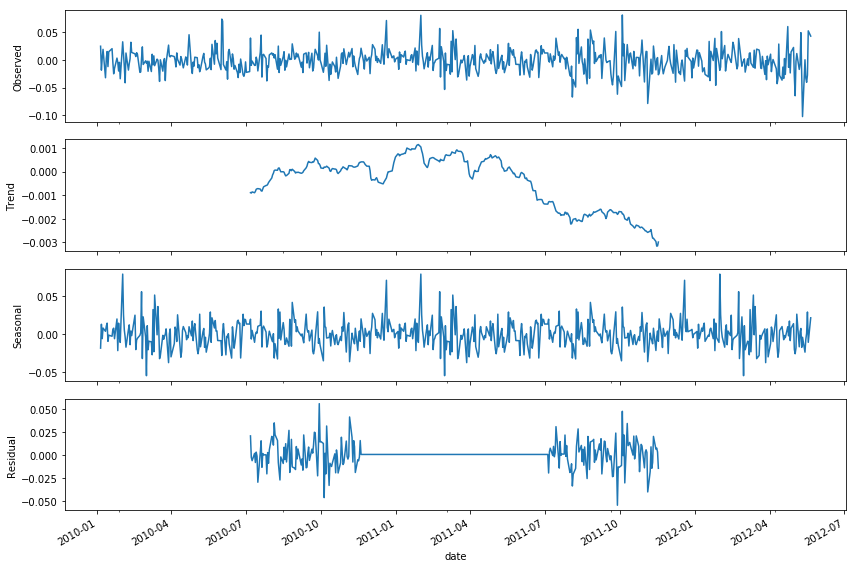

time: 810 ms


In [14]:
regr.inspect_seasonality(price.boxcox);

#### Develop & Fit ARIMA

In [ ]:
_, arima_params = regr.get_best_arima(price.boxcox)
model = smt.ARIMA(price.boxcox, order=arima_params)
model_fit = model.fit(method='mle', trend='nc', update_freq=5)
in_sample_predictions = model_fit.predict()

print(model_fit.summary())

In [ ]:
ex_sample_predictions = regr.predict_rolling_forward(price.boxcox, val_price.boxcox, arima_params)

In [ ]:
regr.is_autocorrelated(price.boxcox, verbose=True);
# After ARIMA modelling the autocorrelation is completely gone
regr.is_autocorrelated(model_fit.resid, verbose=True);

In [ ]:
regr.plot_arima_predictions(price.boxcox, val_price.boxcox, arima_params)

#### Develop & fit GARCH

In [ ]:
arima_residuals = regr.ARIMA_GARCH(price.boxcox, *arima_params, 1, 1).arima_fit.resid
_, garch_params = regr.get_best_garch(arima_residuals)
plot.tsplot(arima_residuals**2);

In [ ]:
# Result from last block: PACF is considerable until lag=5
garch_params = (5, 5) # p = lagged variance, q = lagged residuals
model = regr.ARIMA_GARCH(price.boxcox, *arima_params, *garch_params, vol_model='GARCH')
print(model.garch_fit.summary())

In [ ]:
ex_sample_predictions = regr.plot_garch_predictions(price.boxcox, val_price.boxcox, arima_params, garch_params, vol_model='GARCH')

### Correlate Industry-wise

In [11]:
industry_symbols = [x[0] for x in industry]
ind_props = pd.DataFrame(
    index=industry_symbols, columns=[
    'arima_p', 'arima_d', 'arima_q', 'unit_root', 'autocorr', 'normal_dist', 'heteroscedastic', 'breaks'])
ind_resid_props = pd.DataFrame(ind_props)
industry_orig_prices = pd.DataFrame([x[2].open.rename(x[0]) for x in industry]).T
industry_prices = pd.DataFrame([x[2].boxcox.rename(x[0]) for x in industry]).T
price_resids = pd.DataFrame(index=industry_prices.index, columns=industry_symbols)
for symbol, comp_name, comp_price in tqdm(industry):
    _, arima_params = regr.get_best_arima(comp_price.boxcox, verbose=False)
    model = smt.ARIMA(comp_price.boxcox, order=arima_params)
    model_fit = model.fit(method='mle', trend='nc', update_freq=5)
    price_resids.loc[:, symbol] = model_fit.resid
    ind_props.loc[symbol] = (*arima_params, *regr.investigate(comp_price.boxcox))
    ind_resid_props.loc[symbol] = (*arima_params, *regr.investigate(model_fit.resid))

c:\users\thomas\hpi\ma\venv\lib\site-packages\statsmodels\tsa\tsatools.py:650: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
c:\users\thomas\hpi\ma\venv\lib\site-packages\statsmodels\tsa\tsatools.py:650: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
c:\users\thomas\hpi\ma\venv\lib\site-packages\statsmodels\tsa\tsatools.py:651: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
c:\users\thomas\hpi\ma\venv\lib\site-packages\statsmodels\tsa\tsatools.py:651: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
c:\users\thomas\hpi\ma\venv\lib\site-packages\statsmodels\tsa\tsatools.py:606: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
c:\users\thomas\hpi\ma\venv\lib\site-packages\statsmodels\tsa\tsatools.py:607: Runt

time: 3min 35s


In [12]:
print(all(ind_resid_props == ind_props))
ind_resid_props.head()

True


,arima_p,arima_d,arima_q,unit_root,autocorr,normal_dist,heteroscedastic,breaks
APA,4,0,1,0,0,0,1,0
APC,4,0,2,0,0,0,1,0
BHI,4,0,1,0,0,0,1,0
CHK,3,0,1,0,0,0,1,0
COG,4,0,3,0,0,0,1,0


time: 200 ms


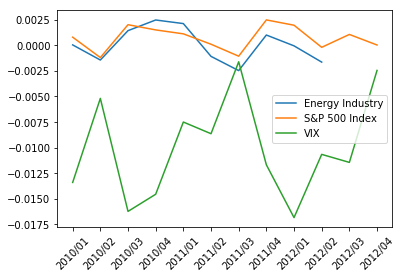

time: 405 ms


In [13]:
plot.plot_performance_quarterly(industry_prices, label='Energy Industry')
plot.plot_performance_quarterly(gspc.boxcox, label='S&P 500 Index')
plot.plot_performance_quarterly(vix.boxcox, label='VIX')
plt.legend();

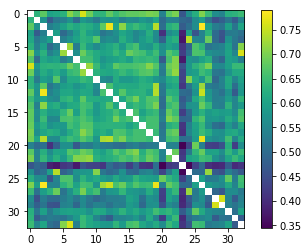

time: 861 ms


In [14]:
correlations = pd.DataFrame(np.nan, index=industry_symbols, columns=industry_symbols)
for a, b in tqdm(itertools.product(industry_symbols, industry_symbols)):
    if a <= b:
        continue
    correlations.loc[a, b] = math_utils.correlation(price_resids.loc[:, a], price_resids.loc[:, b])
    correlations.loc[b, a] = correlations.loc[a, b]

plt.imshow(correlations)
plt.colorbar();

Correlate BHI and SLB:
Pearson's r = 0.79 (without preprocessing: 0.88)
Correlate OKE and RIG:
Pearson's r = 0.34 (without preprocessing: -0.51)


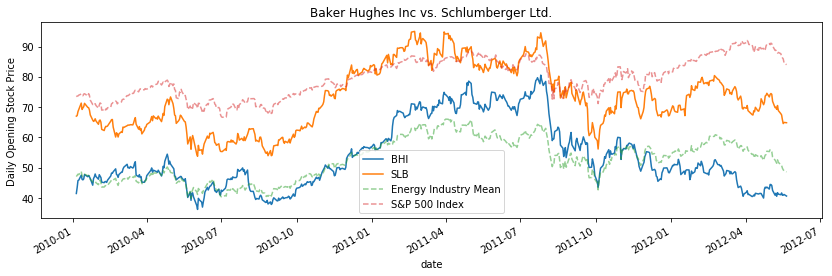

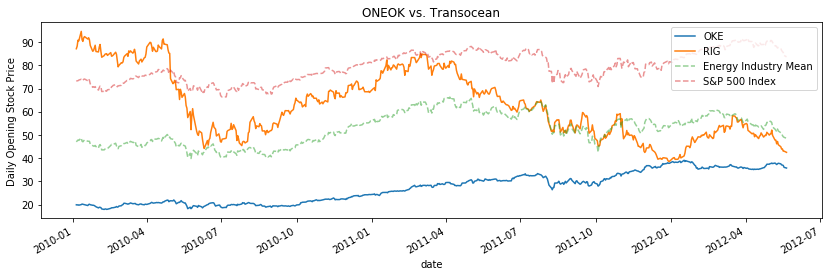

time: 882 ms


In [15]:
stack = correlations.stack()
pair = stack.idxmax()
plot.compare_industry_players(pair, correlations.loc[pair], industry_orig_prices, gspc.open, securities)

pair = stack.idxmin()
plot.compare_industry_players(pair, correlations.loc[pair], industry_orig_prices, gspc.open, securities)

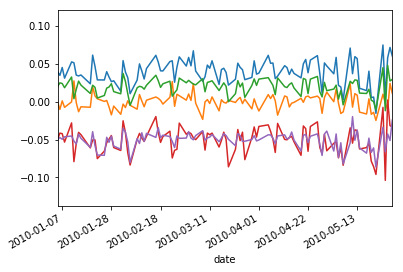

time: 2.55 s


In [17]:
ts = industry_orig_prices.loc[:, pair[0]].pct_change().fillna(0)
exog = pd.DataFrame([industry_orig_prices.mean(axis=1).pct_change().fillna(0).rename('ind'), gspc.open.pct_change().fillna(0).rename('gspc')]).T.dropna()
# industry_orig_prices.mean(axis=1).pct_change().fillna(0)

mdl = smt.ARIMA(ts, exog=exog, order=(5, 0, 3)).fit(method='mle', trend='nc')

(ts + 0.04).plot()
plt.plot(mdl.resid)
plt.plot(mdl.fittedvalues + 0.02)
plt.plot(exog - 0.05)
plt.xlim((ts.index[0], ts.index[100]));

In [23]:
aic_values = regr.get_best_arima(ts, p=range(9, 20), q=range(3, 4), exog=exog, debug=True)

Best AIC: -3844.2186 (worst: -3856.1580) | params: 19, 0, 3
time: 42min 20s


In [ ]:
# (9, 0, 3)

In [22]:
aic_values.idxmax()

(9, 0, 3)

time: 181 ms


In [ ]:
mdl = smt.ARIMA(ts, exog=exog, order=(19, 0, 3)).fit(method='mle', trend='nc')
mdl.summary()
plt.plot(ts)
plt.plot(mdl.fittedvalues)

### Graph

#### Setup

In [ ]:
import networkx as nx
# https://networkx.github.io/documentation/stable/tutorial.html
import visJS2jupyter
import visJS2jupyter.visJS_module as visJS_module
# http://compbio.ucsd.edu/bringing-interactivity-network-visualization-jupyter-notebooks-visjs2jupyter/

# https://github.com/ucsd-ccbb/visJS2jupyter/blob/master/visJS2jupyter/visJS_module.py
# http://compbio.ucsd.edu/bringing-interactivity-network-visualization-jupyter-notebooks-visjs2jupyter/
def display_interactive_graph(G, output_file=None):
    # Prepare graph data
    V = list(G.nodes())
    E = list(G.edges())
    pos = nx.spring_layout(G)

    V_enriched = [(x, securities.get_company_name(x), securities.get_industry(x)) for x in V]
    colors = get_colors(np.unique([x[2] for x in V_enriched]))

    nodes_dict = [{"id":n,
                   "title": f'{comp} ({industry})',
                   "color": colors[industry],
                   "border_width": 0.3,
                   "x":pos[n][0]*1000,
                   "y":pos[n][1]*1000} for (n, comp, industry) in V_enriched]
    node_map = dict(zip(V, range(len(V))))
    edges_dict = [{"id": f'{coocs[E[i]]:n} articles', "source": node_map[E[i][0]], "target": node_map[E[i][1]],
                   "width": 5 * coocs[E[i]] / features.cooccurrence.max()} for i in range(len(E))]
    return visJS_module.visjs_network(nodes_dict, edges_dict, time_stamp=1000000, node_size_multiplier=7,
                                      edge_width_field='width', edge_label_field='none',
                                      graph_height=500, graph_width=900, export_network=bool(output_file), export_file=output_file)

def generate_graph(edges):
    edges = [(idx[0], idx[1], { 'cooc': max(val.cooccurrence / features.cooccurrence.max(), 0.2) })
             for idx, val in edges.iterrows()]
    G = nx.Graph(title='number_of_shared_articles')
    G.add_weighted_edges_from([(x[0], x[1], x[2]['cooc']) for x in edges])
    return G

#### Generate

### TO READ

- https://shishirshakya.blogspot.com/2015/06/the-todayamamoto-approach-to-granger.html
- On Plotting https://robert-alvarez.github.io/2018-06-04-diagnostic_plots/

In [ ]:
def inspect_forecast(model_fit, train, val):
    # multi-step out-of-sample forecast
    start_index = len(train)
    end_index = start_index + len(val) - 1
    ex_sample_forecast = model_fit.predict(start=start_index, end=end_index)
    ex_sample_forecast.index = val.index

    in_sample_forecast = model_fit.predict(len(train)-101, len(train)-1)

    plt.plot(train.iloc[-100:])
    plt.plot(val, 'b--', alpha=0.2)
    plt.plot(in_sample_forecast, color='orange', alpha=0.2)
    plt.plot(ex_sample_forecast, color='orange')

inspect_forecast(model_fit, train, val)